In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# fetch_ml_data function has been deprecated, so we need to do some reordering to get the dataset
# in the same state as the textbook
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

(-0.5, 27.5, 27.5, -0.5)

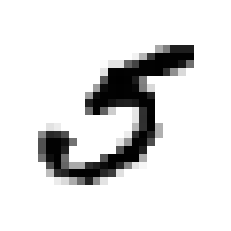

In [4]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")

In [6]:
# Looks like a 5, which is what the label tells us
y[36000]

5

In [7]:
# MNIST data is already split into test and train sets, let's create them

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# Let's shuffle the data so that all cross-validation folds will be similar
# We also do not want one fold to be missing some of the digits
# Some learning algorithms are also sensitive to the order of the training instances,
# and they perform poorly if they get many similar instances in a row

import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [9]:
# Let's try to identify just one digit for now
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
# Correct prediction in this case
sgd_clf.predict([some_digit])

array([ True])

In [14]:
# Measuring accuracy using cross-validation
# Let's implement cross-validation ourselves; it can be useful to have more control over the
# cross-validation process than cross_val_score() provides
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9598
0.96295
0.9596


Recall that K-fold cross-validation means splitting the training set into K-folds (three in this case), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. Each iteration creates a clone of the classifier, trains the clone on the training folds, and makes predictions on the test fold to output the ratio of correct outputs.

In [15]:
from sklearn.model_selection import cross_val_score

# Same thing using the built in cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9598 , 0.96295, 0.9596 ])

In [18]:
# The accuracy of these folds looks really good at over 95% -- let's look at a very
# dumb classifier that just classifies every single image in the "not-5" class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9109 , 0.90855, 0.9095 ])

This has around 90% accuracy, simply because only about 10% of the dataset are 5s, so if you always guess that an image is <i>not</i> a 5, you will be right about 90% of the time.

This demonstrates why accuracy is not generally the preferred performance measure for classifiers, especially when dealing with <i>skewed datasets</i> (datasets that have some classes much more frequently than others).

A much better way to evaluate the performance of a classifier is to look at the <i>confusion matrix</i>. This shows us the number of times instances of class A are classified as class B. For example, to see the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

In [21]:
# Let's keep the test set untouched until the end of the project, when we have a classifier ready to launch
from sklearn.model_selection import cross_val_predict

# cross_val_predict() returns the predictions made on each test fold, rather than the evaluation scores
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53031,  1548],
       [  805,  4616]])

The rows represent the <i>actual class</i>, while columns represent the <i>predicted class</i>. 

Row 1 represents non-5 images: 53,031 were correctly classified as non-5s (true negatives), and 1,548 were incorrectly classified as 5s (false positives). 

Row 2 represents images of 5s: 805 were wrongly classified as 5s (false negatives), while 4,616 were correctly classified as 5s (true positives).

A perfect classifier would have non-zero values only on its main diagonal, representing only true positives and true negatives.

The <i>precision</i> of a classifier is the accuracy of the positive predictions:

precision = $\frac {TP} {TP + FP}$

Precision is usually used along with </i>recall</i>, also called <i>sensitivity</i> or the <i>true positive rate</i>. This is the ratio of positive instances that are correctly detected by the classifier.

recall = $\frac {TP} {TP + FN}$

In [24]:
from sklearn.metrics import precision_score, recall_score

# When the classifier claims an image represents a 5, it is only correct 75% of the time
precision_score(y_train_5, y_train_pred)

0.7488643737832577

In [26]:
# The classifier only detects 85% of the 5s
recall_score(y_train_5, y_train_pred)

0.8515034126544918

It can be useful to combine precision and recall into a single metric called the $F_{1}$ score, especially if you need a simple way to compare two classifiers. The $F_{1}$ score is the harmonic mean of precision and recall. The harmonic mean gives much more weight to low values, meaning that a classifier only gets a high $F_{1}$ score if both recall and precision are high.

$F_{1}$ = $2 \times \frac {precision \times recall} {precision + recall}$

In [28]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))
print(2 * (0.74886 * 0.85150) / (0.74886 + 0.85150))

0.7968925334484247
0.7968885625734209


The $F_{1}$ score favors classifiers that have similar precision and recall. However, this is not always what you want: in some contexts, you care mostly about precision, and in others, you care more about recall. For example, with a classifier trained to detect videos safe for kids, you would probably prefer a classifier that only keeps safe videos (high precision) and rejects many good videos (low recall). If you're training a classifier to detect shoplifters on surveillance images, it might be OK to have only 30% precision as long as it has 99% recall (meaning the security guards get some false alerts, but almost all shoplifters will be flagged).

Increasing precision reduces recall, and vice versa. This is called the <i>precision/recall tradeoff.</i>

In [29]:
# Raising the threshold to be in a positive class for the SGDClassifier will increase precision
# but reduce recall. Conversely, lowering the threshold increases recall and reduces precision.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3608.52502868])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
# SGDClassifier uses a threshold equal to 0, so this is the same result as the predict method
y_some_digit_pred

array([ True])

In [31]:
# Let's raise the threshold
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
# This confirms that raising the threshold reduces recall
y_some_digit_pred

array([False])

In [32]:
# So how do we decide which threshold to use?
# First, get the scores of all instances in the training set using cross_val_predict()
# but this time return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [33]:
# Now we'll compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [54]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

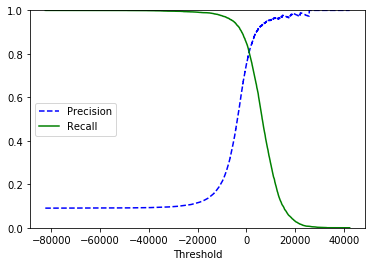

In [57]:
# Precision curve has some bumps in it because precision may sometimes go down when the threshold
# is increased (although it generally goes up)
# Recall can only go down when the threshold is increased
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [62]:
# Now we can select the threshold value that gives us the best precision/recall tradeoff for the task
# Let's suppose we want around 90% precision, which means a threshold of around 5,000
y_train_pred_90 = (y_scores > 5000)
precision_score(y_train_5, y_train_pred_90)

0.916083916083916

In [63]:
recall_score(y_train_5, y_train_pred_90)

0.6041320789522229

<h3>The ROC Curve</h3>

The <i>receiver operating characteristic</i> (ROC) curve is another common tool usedd with binary classifiers. Instead of plotting precision versus recall, the ROC curve plots the <i>true positive rate</i> (another name for recall) against the <i>false positive rate</i>. The FPR is the ratio of negative instances that are incorrectly classified as positive. It equals 1 minus the <i>true negative rate</i>, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called <i>specificity</i>. The ROC curve plots <i>sensitivity</i> (recall) versus 1 - <i>specificity</i>.

In [64]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [65]:
def plot_roc_curve(fpr, tpr, label=None):
    

SyntaxError: invalid syntax (<ipython-input-65-21bad38f9600>, line 1)